In [78]:
#Import Statements
import os, itertools
import warnings
from matplotlib.pyplot import text
from numpy import vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
import re
import numpy as np
import warnings
import statistics
import math
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from JaccardIndexUpdated import JaccardIndex, ClustersData, summary
from sklearn.decomposition import TruncatedSVD
from CleanText import getCleanText, getDataFrame
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from VectorizeHelperFunction import allScores
from CleanText import getCleanText, getText
import umap
import umap.plot
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
from django.urls import re_path as url
import holoviews as hv
import holoviews.operation.datashader as hd 
import umap
import umap.plot
import hdbscan
import time
import seaborn as sns


In [2]:
def printScores(df, labels):
    print("Silhouette Score:", silhouette_score(df, labels))
    print("Davies Bouldin Score:", davies_bouldin_score(df, labels))
    print("Calinski:", calinski_harabasz_score(df, labels))

In [21]:
text_l, labels = getCleanText("FinancialFilesTextClean", RemoveNums= True)

In [64]:
#rawText, labels = getText("FinancialFilesTextClean")
rawTextNew, labelsNew = getText("FinancialFilesTextClean")

In [ ]:
print(text_l[0])

In [65]:
#Normal take in data
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
startTimeTFIDF = time.perf_counter()
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange, norm = 'l1')
tfidf_wm = tfidfvectorizer.fit_transform(rawTextNew)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labelsNew,columns = tfidf_tokens)
endTimeTFIDF = time.perf_counter()

startTimeSVD = time.perf_counter()
svd = TruncatedSVD(n_components= 20)
reducedSVD = svd.fit_transform(df_tfidfvect)
endTimeSVD = time.perf_counter()

startTimeUMAP = time.perf_counter()
umapVectorizer = umap.UMAP(metric = 'cosine', n_neighbors = 10 , min_dist = 0.1)
reducedUMAP = umapVectorizer.fit_transform(df_tfidfvect)
endTimeUMAP = time.perf_counter()

fitUMAP = umapVectorizer.fit(df_tfidfvect)

print(f'\nTFIDF Time: {(endTimeTFIDF - startTimeTFIDF) / 60}')
print(f'SVD Time: {(endTimeSVD - startTimeSVD) / 60}')
print(f'UMAP Time: {(endTimeUMAP - startTimeUMAP) / 60}\n')



TFIDF Time: 0.018895159999859364
SVD Time: 0.025048149999929593
UMAP Time: 0.06739871333314416



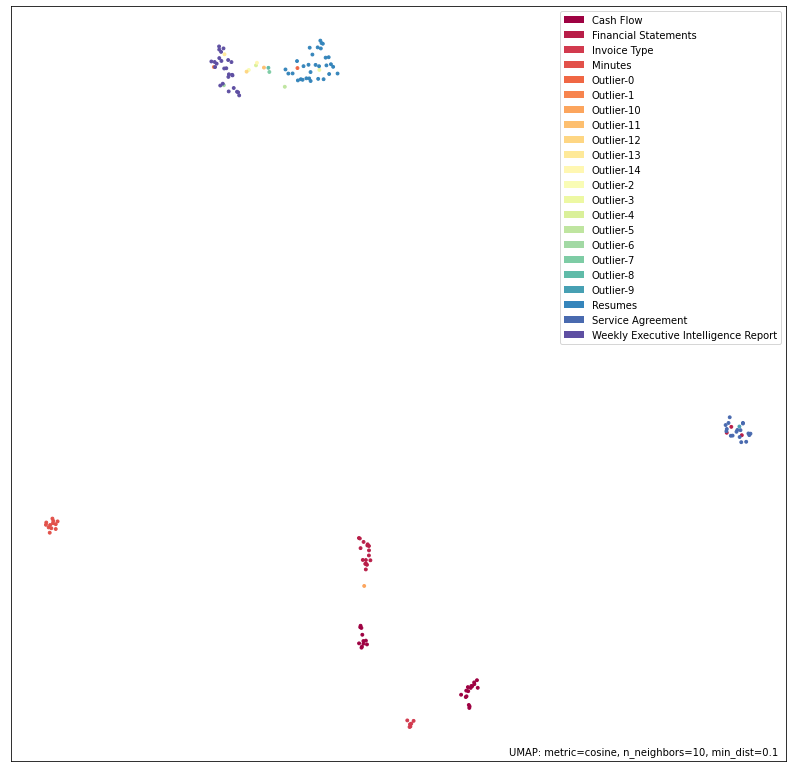

In [86]:
fig = umap.plot.points(fitUMAP, labels = np.array(labelsNew), width = 1000, height = 1000)

In [ ]:
umap.plot.diagnostic(fitUMAP, diagnostic_type='neighborhood')

In [76]:
start_time = time.perf_counter()
#clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples=5, cluster_selection_method = 'leaf')


clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples=10)
clusterer.fit(reducedUMAP)
end_time = time.perf_counter()

print(f'\nTime: {(end_time - start_time) / 60}\n')

clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
df = pd.DataFrame(data = clusterDict, index = labelsNew)
#print(df.to_string())
clusterProbabilities = clusterer.probabilities_
clusterLabels = clusterer.labels_
outlierScores = clusterer.outlier_scores_
negative = -1
for x in range(len(clusterLabels)):
    if(clusterLabels[x] == -1):
        clusterLabels[x] = negative
        negative = negative - 1


clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities, "Outlier Scores": outlierScores}
df = pd.DataFrame(data = clusterDict, index = labelsNew)

print("Number of clusters:", len(set(clusterLabels)))
print("Number of documents:", len(clusterLabels))

print(homogeneity_score(labelsNew, clusterLabels))
print(completeness_score(labelsNew, clusterLabels))

print(df.to_string())



Time: 7.185833334612349e-05

Number of clusters: 7
Number of documents: 153
0.707413579454951
0.9019849049440006
                                      Cluster Label  Cluster probabilities  Outlier Scores
Cash Flow                                         2               0.376402        0.623598
Cash Flow                                         2               0.443720        0.556280
Cash Flow                                         2               0.437411        0.562589
Cash Flow                                         2               0.905484        0.094516
Cash Flow                                         2               0.976529        0.023471
Cash Flow                                         2               1.000000        0.000000
Cash Flow                                         2               1.000000        0.000000
Cash Flow                                         2               0.893822        0.106178
Cash Flow                                         2               0

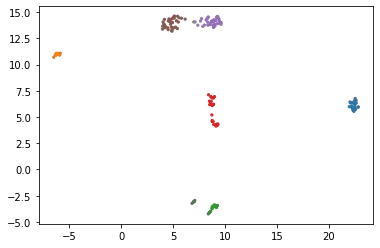

In [85]:
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(reducedUMAP[:,0], reducedUMAP[:,1], s=5, c=cluster_member_colors, alpha=1)

In [ ]:
#Find best UMAP parameters
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawText)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labels,columns = tfidf_tokens)

svd = TruncatedSVD(n_components= 20)
reducedSVDRaw = svd.fit_transform(df_tfidfvect)

neighbors = [2, 5, 10]
dist = [0.0, 0.1, 0.5]
umapVectorizer = umap.UMAP(metric = 'cosine')
print(len(neighbors))
print(len(dist))
for x in neighbors:
    print("Neighbors:", x)
    for y in dist:
        print("Dist:", y)
        umapVectorizer = umap.UMAP(n_neighbors= x, min_dist = y, metric = 'cosine')
        reducedUMAPRaw = umapVectorizer.fit_transform(df_tfidfvect)
        printScores(reducedUMAPRaw, labels)
        #clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples=5 )
        clusterer = hdbscan.HDBSCAN(algorithm = 'best')
        clusterer.fit(reducedUMAPRaw)
        clusterProbabilities = clusterer.probabilities_
        clusterLabels = clusterer.labels_
        negative = -1
        for x in range(len(clusterLabels)):
            if(clusterLabels[x] == -1):
                clusterLabels[x] = negative
                negative = negative - 1
        clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities}
        df = pd.DataFrame(data = clusterDict, index = labels)

        print("Number of clusters:", len(set(clusterLabels)))
        print("Number of documents:", len(clusterLabels))

        print(homogeneity_score(labels, clusterLabels))
        print(completeness_score(labels, clusterLabels))

In [ ]:
import time
start_time = time.perf_counter()
#clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=2, min_samples=5 )
clusterer = hdbscan.HDBSCAN(algorithm = 'best')
clusterer.fit(reducedUMAPRaw)
end_time = time.perf_counter()

print(f'\nTime: {(end_time - start_time) / 60}\n')

clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
df = pd.DataFrame(data = clusterDict, index = labels)
#print(df.to_string())
clusterProbabilities = clusterer.probabilities_
clusterLabels = clusterer.labels_
negative = -1
for x in range(len(clusterLabels)):
    if(clusterLabels[x] == -1):
        clusterLabels[x] = negative
        negative = negative - 1


clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities}
df = pd.DataFrame(data = clusterDict, index = labels)

print("Number of clusters:", len(set(clusterLabels)))
print("Number of documents:", len(clusterLabels))

print(homogeneity_score(labels, clusterLabels))
print(completeness_score(labels, clusterLabels))

print(df.to_string())


In [18]:
#Find best clustering parameters
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawText)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labels,columns = tfidf_tokens)

svd = TruncatedSVD(n_components= 20)
reducedSVDRaw = svd.fit_transform(df_tfidfvect)
umapVectorizer = umap.UMAP(metric = 'cosine')
reducedUMAPRaw = umapVectorizer.fit_transform(df_tfidfvect)



In [ ]:
clusterSizes = [2, 5, 10, 15, 30]
samples = [1, 2, 5, 10 ,15, 30]

for z in clusterSizes:
    for y in samples:
        print("Minimum Cluster Sizes:", z)
        print("Sample Size:", y)
        clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=z, min_samples=y )
        clusterer.fit(reducedUMAPRaw)

        clusterProbabilities = clusterer.probabilities_
        clusterLabels = clusterer.labels_
        negative = -1
        for x in range(len(clusterLabels)):
            if(clusterLabels[x] == -1):
                clusterLabels[x] = negative
                negative = negative - 1

        clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities}
        df = pd.DataFrame(data = clusterDict, index = labels)

        print("Number of clusters:", len(set(clusterLabels)))
        print("Number of documents:", len(clusterLabels))

        print(homogeneity_score(labels, clusterLabels))
        print(completeness_score(labels, clusterLabels))
        print()

#print(df.to_string())

In [ ]:
#Combine UMAP and Clustering
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawText)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labels,columns = tfidf_tokens)

svd = TruncatedSVD(n_components= 20)
reducedSVDRaw = svd.fit_transform(df_tfidfvect)

neighbors = [5, 10, 20]
dist = [0.0, 0.1]
umapVectorizer = umap.UMAP(metric = 'cosine')
print(len(neighbors))
print(len(dist))
for x in neighbors:
    for y in dist:
        print("Neighbors:", x)
        print("Dist:", y)
        umapVectorizer = umap.UMAP(n_neighbors= x, min_dist = y, metric = 'cosine')
        reducedUMAPRaw = umapVectorizer.fit_transform(df_tfidfvect)
        clusterSizes = [2]
        samples = [1, 2, 5, 10 ,15, 30]

        for i in clusterSizes:
            for j in samples:
                print("Minimum Cluster Sizes:", i)
                print("Sample Size:", j)
                clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=i, min_samples=j )
                clusterer.fit(reducedUMAPRaw)

                clusterProbabilities = clusterer.probabilities_
                clusterLabels = clusterer.labels_
                negative = -1
                for k in range(len(clusterLabels)):
                    if(clusterLabels[k] == -1):
                        clusterLabels[k] = negative
                        negative = negative - 1

                clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities}
                df = pd.DataFrame(data = clusterDict, index = labels)

                print("Number of clusters:", len(set(clusterLabels)))
                print(homogeneity_score(labels, clusterLabels))
                print(completeness_score(labels, clusterLabels))
                print()

In [ ]:
#Combine UMAP and Clustering
maxFreq = .8
minFreq = .005
ngramRange = (1,2)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawText)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labels,columns = tfidf_tokens)

components = [2, 5, 10, 20, 30, 40]

for x in components:
    print("Num Components:", x)
    svdVectorizer = TruncatedSVD(n_components=x)
    reducedSVDRaw = svdVectorizer.fit_transform(df_tfidfvect)
    clusterSizes = [2, ]
    samples = [1, 2, 5, 10 ,15, 30]

    for i in clusterSizes:
        for j in samples:
            print("Minimum Cluster Sizes:", i)
            print("Sample Size:", j)
            clusterer = hdbscan.HDBSCAN(algorithm = 'best', min_cluster_size=i, min_samples=j )
            clusterer.fit(reducedSVDRaw)

            clusterProbabilities = clusterer.probabilities_
            clusterLabels = clusterer.labels_
            negative = -1
            for k in range(len(clusterLabels)):
                if(clusterLabels[k] == -1):
                    clusterLabels[k] = negative
                    negative = negative - 1

            clusterDict = {"Cluster Label": (clusterLabels), "Cluster probabilities": clusterProbabilities}
            df = pd.DataFrame(data = clusterDict, index = labels)

            print("Number of clusters:", len(set(clusterLabels)))
            print(homogeneity_score(labels, clusterLabels))
            print(completeness_score(labels, clusterLabels))
            print()

In [7]:
#Analyzing Outliers
"""maxFreq = .8
minFreq = .005
ngramRange = (1,2)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, min_df = minFreq, max_df = .8, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(rawTextNew)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = labelsNew,columns = tfidf_tokens)

svd = TruncatedSVD(n_components= 20)
reducedSVDRaw = svd.fit_transform(df_tfidfvect)
umapVectorizer = umap.UMAP(metric = 'cosine', n_neighbors = 10, min_dist= .1)
reducedUMAPRaw = umapVectorizer.fit_transform(df_tfidfvect)"""

In [272]:
from scipy import spatial 
#Outlier 81  and 10 are similar 
firstDocCosines = []
firstDocDistances = []
print(labelsNew[64])
print(labelsNew[67])
print(labelsNew[70])

print()
for i in range(len(labelsNew)):
    firstDocCosines.append(1 - spatial.distance.cosine(reducedSVD[i], reducedSVD[67]))
    firstDocDistances.append(np.linalg.norm(reducedSVD[i] - reducedSVD[67]))

distances = {"Labels": labelsNew, "Cosine Distance": firstDocCosines, "Euclidean Distance": firstDocDistances}
distanceDF = pd.DataFrame(data = distances)
print(distanceDF.to_string())
print(labelsNew[64])
print(rawTextNew[64][:200])
print()
print(labelsNew[67])
print(rawTextNew[67][:200])
print()
print(labelsNew[70])
print(rawTextNew[70][:200])
print()

Outlier-0
Outlier-3
Outlier-6

                                   Labels  Cosine Distance  Euclidean Distance
0                               Cash Flow         0.069361            1.026341
1                               Cash Flow         0.066092            1.035379
2                               Cash Flow         0.069216            1.031696
3                               Cash Flow         0.046432            1.057040
4                               Cash Flow         0.053662            1.042245
5                               Cash Flow         0.048417            1.063212
6                               Cash Flow         0.047282            1.064076
7                               Cash Flow         0.048226            1.059376
8                               Cash Flow         0.047684            1.060212
9                               Cash Flow         0.058722            1.052252
10                              Cash Flow         0.041781            1.065125
11                   